In [5]:
import pandas as pd
import ast
import re
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from scipy.stats import randint

df = pd.read_excel("fr_tfidf.xlsx")
y = df["label"]

def clean_tfidf(x):
    s = str(x)
    s = s.replace("np.float64", "")
    s = s.replace("float64", "")
    s = s.replace("float32", "")
    s = re.sub(r"defaultdict\([^)]*\),?\s*", "", s)
    s = re.sub(r"\(\s*([0-9.]+)\s*\)", r"\1", s)
    return ast.literal_eval(s)

tfidf_dicts = df["TFIDF"].apply(clean_tfidf)

vec = DictVectorizer(sparse=True)
X = vec.fit_transform(tfidf_dicts)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

param_dist = {
    "n_estimators": randint(300, 1200),
    "max_depth": [None, 30, 50, 70, 90, 100],
    "min_samples_split": randint(2, 60),
    "min_samples_leaf": randint(1, 15),
    "max_features": ["sqrt", "log2"],
    "bootstrap": [True]
}

model = RandomForestClassifier(random_state=42, n_jobs=-1)

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=60,
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

print("\n=== BEST PARAMS ===")
print(random_search.best_params_)

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

print("\n=== EVALUATION REPORT ===")
print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 60 candidates, totalling 180 fits

=== BEST PARAMS ===
{'bootstrap': True, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 59, 'n_estimators': 863}

=== EVALUATION REPORT ===
              precision    recall  f1-score   support

          CG       0.85      0.92      0.88      4044
          OR       0.91      0.83      0.87      4043

    accuracy                           0.88      8087
   macro avg       0.88      0.88      0.87      8087
weighted avg       0.88      0.88      0.87      8087



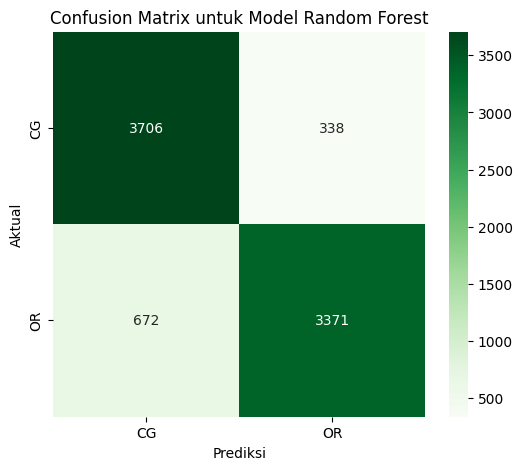

In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
labels = ["CG", "OR"]

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=labels, yticklabels=labels)

plt.title("Confusion Matrix untuk Model Random Forest")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()